# Cyclistic — Prepare ▶ Process ▶ Analyze ▶ Share ▶ Act
(Explanation: Run top-to-bottom; replace placeholder text with your specifics.)

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
RAW=Path('data/raw'); PROC=Path('data/processed'); FIGS=Path('figures')
PROC.mkdir(parents=True,exist_ok=True); FIGS.mkdir(parents=True,exist_ok=True)

## Prepare (load 12 CSVs)
(Explanation: Drop monthly CSVs into `data/raw/`.)

In [61]:
files=sorted(RAW.glob('*.csv'))
assert len(files)>=3, 'Add monthly CSVs into data/raw/'
dfs=[pd.read_csv(f) for f in files]
rides=pd.concat(dfs, ignore_index=True)
print(rides.shape); rides.head()

(5539521, 13)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,4422E707103AA4FF,electric_bike,2024-10-14 03:26:04.083,2024-10-14 03:32:56.535,NaN,NaN,NaN,NaN,41.96,-87.65,41.98,-87.67,member
1,19DB722B44CBE82F,electric_bike,2024-10-13 19:33:38.926,2024-10-13 19:39:04.490,NaN,NaN,NaN,NaN,41.98,-87.67,41.97,-87.66,member
2,20AE2509FD68C939,electric_bike,2024-10-13 23:40:48.522,2024-10-13 23:48:02.339,NaN,NaN,NaN,NaN,41.97,-87.66,41.95,-87.65,member
3,D0F17580AB9515A9,electric_bike,2024-10-14 02:13:41.602,2024-10-14 02:25:40.057,NaN,NaN,NaN,NaN,41.95,-87.65,41.96,-87.65,member
4,A114A483941288D1,electric_bike,2024-10-13 19:26:41.383,2024-10-13 19:28:18.560,NaN,NaN,NaN,NaN,41.98,-87.67,41.98,-87.67,member


## Process (clean + features)
(Explanation: Parse datetimes, compute ride_length, day_of_week, month, hour; filter outliers.)

In [62]:
for col in ['started_at','ended_at']:
    rides[col]=pd.to_datetime(rides[col], errors='coerce')
rides['ride_length_min']=(rides['ended_at']-rides['started_at']).dt.total_seconds()/60
rides['day_of_week']=rides['started_at'].dt.day_name()
rides['month']=rides['started_at'].dt.to_period('M').astype(str)
rides['hour']=rides['started_at'].dt.hour
rides=rides[(rides['ride_length_min']>1)&(rides['ride_length_min']<720)].dropna(subset=['member_casual','started_at','ended_at'])
print(rides.shape)

(5395516, 17)


### Save clean data

In [63]:
rides.to_parquet(PROC/'cyclistic_clean.parquet', index=False)
rides.sample(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length_min,day_of_week,month,hour
902562,3CF11D2B423E0021,electric_bike,2024-11-01 19:39:55.726,2024-11-01 19:41:01.483,NaN,NaN,NaN,NaN,41.950000,-87.680000,41.940000,-87.680000,member,1.095950,Friday,2024-11,19
4073943,554F8D5BAE11DA8C,electric_bike,2025-08-14 06:29:34.906,2025-08-14 06:51:05.498,NaN,NaN,NaN,NaN,41.930000,-87.710000,41.890000,-87.630000,member,21.509867,Thursday,2025-08,6
969896,D3E656164EF42591,classic_bike,2024-12-11 16:38:16.921,2024-12-11 17:20:44.425,Wells St & Elm St,KA1504000135,Burling St & Diversey Pkwy,TA1309000036,41.903222,-87.634324,41.933140,-87.647760,member,42.458400,Wednesday,2024-12,16
5314519,6FB3A801B5303158,electric_bike,2025-09-25 19:17:25.977,2025-09-25 19:27:42.500,Kingsbury St & Kinzie St,CHI00299,DuSable Lake Shore Dr & North Blvd,CHI00525,41.889183,-87.638484,41.911722,-87.626804,member,10.275383,Thursday,2025-09,19
702746,B55CB72A36CB26E5,electric_bike,2024-11-08 16:47:21.280,2024-11-08 16:54:57.550,Wells St & Randolph St,TA1305000030,Federal St & Polk St,SL-008,41.884295,-87.633963,41.872078,-87.629544,member,7.604500,Friday,2024-11,16


## Analyze (EDA)
(Explanation: Build decision-oriented visuals.)

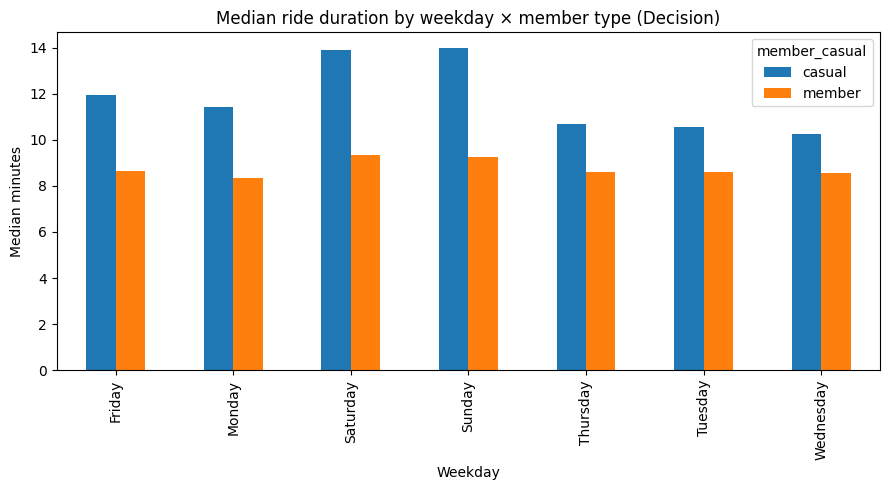

In [64]:
g1=(rides.groupby(['member_casual','day_of_week'])['ride_length_min'].median().reset_index())
p1=g1.pivot(index='day_of_week', columns='member_casual', values='ride_length_min')
ax=p1.plot(kind='bar', figsize=(9,5)); ax.set_title('Median ride duration by weekday × member type (Decision)'); ax.set_xlabel('Weekday'); ax.set_ylabel('Median minutes'); plt.tight_layout(); plt.savefig(FIGS/'fig1_median_duration_weekday.png'); plt.show()

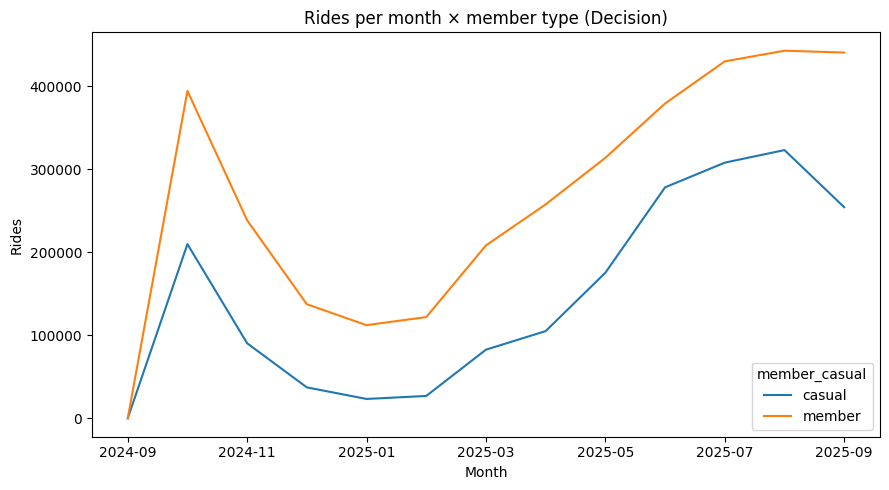

In [65]:
g2=(rides.groupby(['month','member_casual'])['ride_id'].count().reset_index(name='rides'))
p2=g2.pivot(index='month', columns='member_casual', values='rides').fillna(0)
ax=p2.plot(kind='line', figsize=(9,5)); ax.set_title('Rides per month × member type (Decision)'); ax.set_xlabel('Month'); ax.set_ylabel('Rides'); plt.tight_layout(); plt.savefig(FIGS/'fig2_rides_per_month.png'); plt.show()

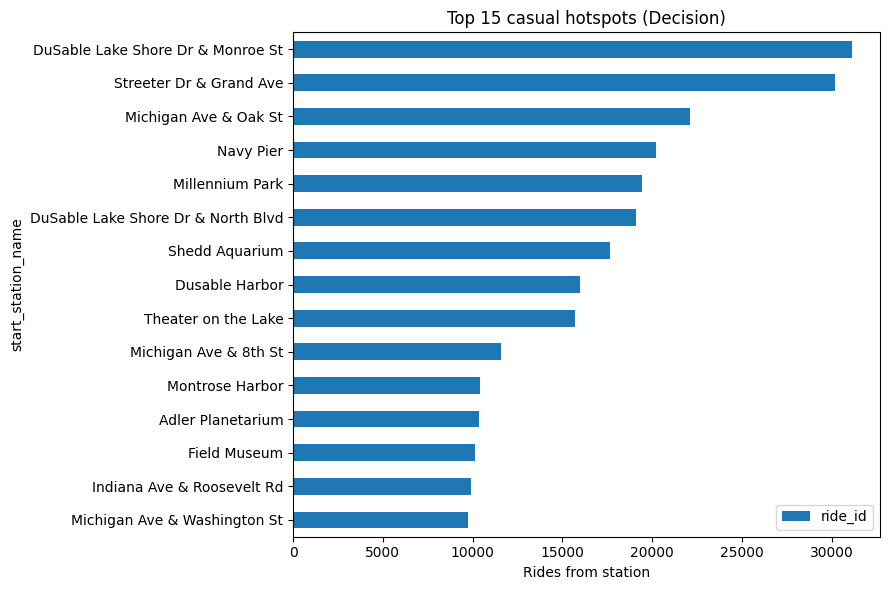

In [66]:
hot=(rides[rides['member_casual']=='casual'].groupby('start_station_name')['ride_id'].count().sort_values(ascending=False).head(15).reset_index())
ax=hot.plot(kind='barh', x='start_station_name', y='ride_id', figsize=(9,6)); ax.invert_yaxis(); ax.set_title('Top 15 casual hotspots (Decision)'); ax.set_xlabel('Rides from station'); plt.tight_layout(); plt.savefig(FIGS/'fig3_top_casual_hotspots.png'); plt.show()

## Share (export key tables)

In [67]:
with pd.ExcelWriter(PROC/'summary_tables.xlsx') as xl:
    g1.to_excel(xl, sheet_name='median_duration_weekday', index=False)
    g2.to_excel(xl, sheet_name='rides_per_month', index=False)
    hot.to_excel(xl, sheet_name='top_casual_hotspots', index=False)
print('Exported summary_tables.xlsx')

Exported summary_tables.xlsx


## Act (sizing sketch)
(Explanation: Replace with your numbers; this is just a scaffold.)

In [68]:
casual_total=int((rides['member_casual']=='casual').sum()); hotspot_reach=int(hot['ride_id'].sum())
print({'casual_total_rides': casual_total, 'hotspot_reach_rides': hotspot_reach})
print('(Explanation: Reach × offer CTR × upgrade rate → projected new members)')

{'casual_total_rides': 1916180, 'hotspot_reach_rides': 253668}
(Explanation: Reach × offer CTR × upgrade rate → projected new members)


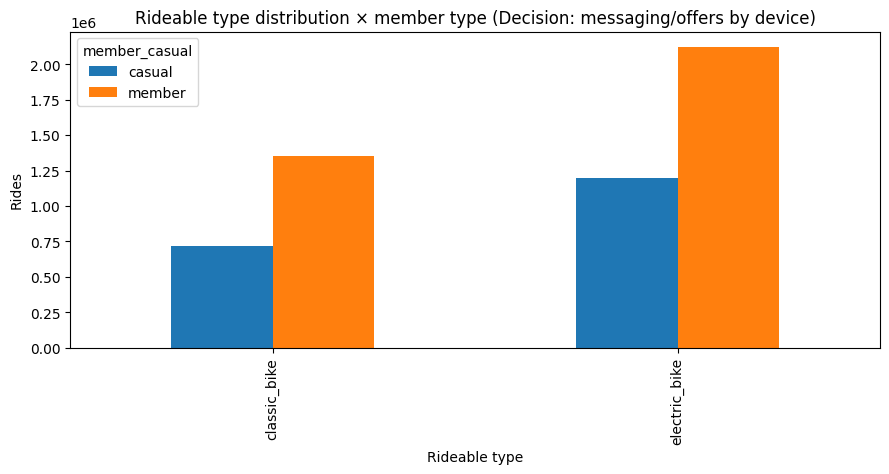

In [69]:
# 4) Device mix — rideable_type distribution × member type
# (Explanation: Helps decide which user segments to target with device-specific messaging.)
mix = (rides.groupby(['member_casual','rideable_type'])['ride_id']
       .count().reset_index(name='rides'))
p4 = mix.pivot(index='rideable_type', columns='member_casual', values='rides').fillna(0)
ax = p4.plot(kind='bar', figsize=(9,5))
ax.set_title('Rideable type distribution × member type (Decision: messaging/offers by device)')
ax.set_xlabel('Rideable type'); ax.set_ylabel('Rides')
import matplotlib.pyplot as plt
plt.tight_layout(); plt.savefig(FIGS/'fig4_device_mix.png'); plt.show()


(hour
 0     True
 1     True
 2     True
 3     True
 4    False
 Name: weekday, dtype: bool,
 hour
 0    True
 1    True
 2    True
 3    True
 4    True
 Name: weekend, dtype: bool)

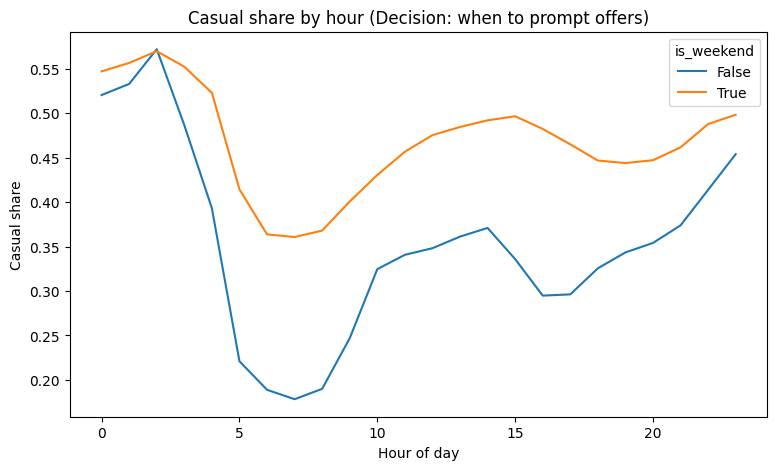

In [70]:
# 5) Casual share by hour × weekend vs weekday
# (Explanation: Pinpoints when to show prompts/ads — weekends afternoons are commonly high.)
rides['is_weekend'] = rides['started_at'].dt.dayofweek >= 5
hourly = (rides.assign(is_casual = rides['member_casual'].eq('casual'))
          .groupby(['is_weekend','hour'])['is_casual']
          .mean().reset_index())
pivot5 = hourly.pivot(index='hour', columns='is_weekend', values='is_casual')
ax = pivot5.plot(kind='line', figsize=(9,5))
ax.set_title('Casual share by hour (Decision: when to prompt offers)')
ax.set_xlabel('Hour of day'); ax.set_ylabel('Casual share')
import matplotlib.pyplot as plt

# Rename columns True/False → 'weekend'/'weekday' and fill any gaps
pivot5_named = pivot5.rename(columns={True: "weekend", False: "weekday"}).fillna(0.0)

# Choose a threshold: 75th percentile within each group (tweak to 0.70/0.80 if you want wider/narrower windows)
thr = pivot5_named.quantile(0.75)
high_weekday = pivot5_named["weekday"] >= thr["weekday"]
high_weekend = pivot5_named["weekend"] >= thr["weekend"]

high_weekday.head(), high_weekend.head()
# (When code below executes: it will convert 0..23 hours to clean ranges like 11:00–17:00; and prints a sentence.)


In [71]:
# Rebuild hourly casual share with ride counts (safe to run even if earlier cells ran)
import pandas as pd
import numpy as np
from pathlib import Path

# Load 'rides' if not in memory
if 'rides' not in globals():
    ROOT = Path.cwd()
    if (ROOT.name == "notebooks") and not (ROOT / "data").exists():
        ROOT = ROOT.parent
    rides = pd.read_parquet(ROOT / "data" / "processed" / "cyclistic_clean.parquet")

rides['is_weekend'] = rides['started_at'].dt.dayofweek >= 5
rides['hour'] = rides['started_at'].dt.hour
rides['is_casual'] = rides['member_casual'].eq('casual')

grp = rides.groupby(['is_weekend','hour'])
counts = grp['ride_id'].count().rename('rides').reset_index()
shares = grp['is_casual'].mean().rename('casual_share').reset_index()

hourly = pd.merge(counts, shares, on=['is_weekend','hour'])
pivot_share = hourly.pivot(index='hour', columns='is_weekend', values='casual_share').fillna(0.0)
pivot_cnt   = hourly.pivot(index='hour', columns='is_weekend', values='rides').fillna(0)

# Rename True/False → weekend/weekday
pivot_share = pivot_share.rename(columns={True:'weekend', False:'weekday'})
pivot_cnt   = pivot_cnt.rename(columns={True:'weekend', False:'weekday'})

# Smooth the curves with a centered 3-hour rolling average
smooth = pd.DataFrame(index=pivot_share.index)
for col in ['weekday','weekend']:
    smooth[col] = pivot_share[col].rolling(3, center=True, min_periods=1).mean()

In [72]:
# Weighted rolling selection of best contiguous daytime windows
import numpy as np
import pandas as pd

# ---- Daytime mask (09–19). Adjust if you prefer 10–18, etc.
day_start, day_end = 9, 19
day_mask = ((pivot_cnt.index >= day_start) & (pivot_cnt.index <= day_end))

# ---- Weighted curves: smoothed share × rides; zero-out non-daytime by using a huge negative
NEG = -1e12
w_weekday = (smooth['weekday'] * pivot_cnt['weekday']).where(day_mask, other=NEG)
w_weekend = (smooth['weekend'] * pivot_cnt['weekend']).where(day_mask, other=NEG)

# ---- Choose contiguous span length (hours)
span_weekday = 3   # 3-hour weekday window
span_weekend = 6   # 6-hour weekend window

roll_wkdy  = w_weekday.rolling(span_weekday, min_periods=span_weekday).sum()
roll_wkend = w_weekend.rolling(span_weekend, min_periods=span_weekend).sum()

# ---- Best start indices (argmax of rolling sums)
best_start_wkdy  = int(roll_wkdy.idxmax())  - (span_weekday  - 1)
best_start_wkend = int(roll_wkend.idxmax()) - (span_weekend - 1)

# ---- Clamp to valid daytime range
best_start_wkdy  = max(day_start, min(day_end - span_weekday + 1,  best_start_wkdy))
best_start_wkend = max(day_start, min(day_end - span_weekend + 1, best_start_wkend))

wkdy_ranges  = [(best_start_wkdy,  best_start_wkdy  + span_weekday  - 1)]
wkend_ranges = [(best_start_wkend, best_start_wkend + span_weekend - 1)]

In [73]:
def format_ranges(ranges):
    if not ranges: return "—"
    parts = []
    for s, e in ranges:
        parts.append(f"{s:02d}:00–{e:02d}:00" if s != e else f"{s:02d}:00–{e:02d}:59")
    return "; ".join(parts)

wkdy_text  = format_ranges(wkdy_ranges)
wkend_text = format_ranges(wkend_ranges)

print("Recommended targeting windows →", {"weekday": wkdy_text, "weekend": wkend_text})
print(
    f"\nCasual share peaks on weekends **{wkend_text}**; "
    f"secondary peak on weekdays **{wkdy_text}**. "
    "Prompts and offers will be concentrated in these windows."
)

Recommended targeting windows → {'weekday': '16:00–18:00', 'weekend': '11:00–16:00'}

Casual share peaks on weekends **11:00–16:00**; secondary peak on weekdays **16:00–18:00**. Prompts and offers will be concentrated in these windows.


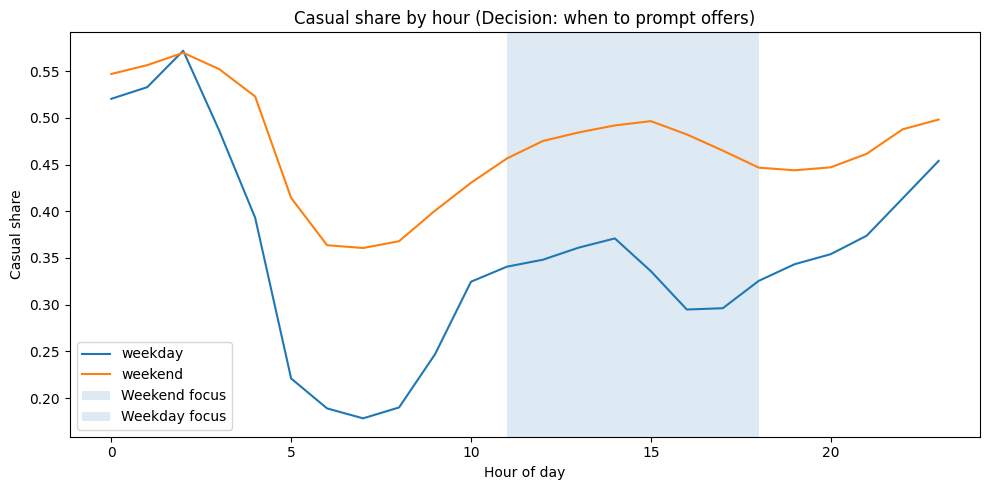

In [74]:
import matplotlib.pyplot as plt

ax = pivot_share.rename(columns={True:'weekend', False:'weekday'}).plot(kind='line', figsize=(10,5))
ax.set_title('Casual share by hour (Decision: when to prompt offers)')
ax.set_xlabel('Hour of day'); ax.set_ylabel('Casual share')

def shade(ax, start, end, label):
    ax.axvspan(start, end, alpha=0.15, label=label)

shade(ax, 11, 16, 'Weekend focus')
shade(ax, 16, 18, 'Weekday focus')
ax.legend()
plt.tight_layout()
plt.savefig(FIGS/'fig5_casual_share_by_hour.png')
plt.show()

## Traffic assumptions — eligible exposures per day
(Explanation: Counts casual rides at top 10 casual hotspots during our focus windows: weekends 11:00–16:00, weekdays 16:00–18:00.)

In [86]:
# Build list of top-N casual hotspot station names for targeting filters
top_n = 10  # increase to 20–30 if you want more daily exposure

hot_stations = (rides[rides['member_casual']=='casual']
                .groupby('start_station_name')['ride_id']
                .count()
                .sort_values(ascending=False)
                .head(top_n)
                .index
                .tolist())

print(f"hot_stations (top {top_n}):", hot_stations[:5], "… total:", len(hot_stations))

hot_stations (top 10): ['DuSable Lake Shore Dr & Monroe St', 'Streeter Dr & Grand Ave', 'Michigan Ave & Oak St', 'Navy Pier', 'Millennium Park'] … total: 10


In [87]:
# Build top-N hotspot station list and compute the 'eligible' subset used for traffic assumptions
# (Explanation: This ensures we always filter by your chosen hotspots + hours, using 'hot_stations'.)

# 1) Ensure hot_stations exists (list of station names)
top_n = 10  # (Explanation: increase to 20–30 if you want more daily exposure / shorter timeline)
if 'hot_stations' not in globals():
    hot_stations = (rides[rides['member_casual']=='casual']
                    .groupby('start_station_name')['ride_id']
                    .count()
                    .sort_values(ascending=False)
                    .head(top_n)
                    .index
                    .tolist())

# 2) Define targeting hours (keep in sync with your recommendations)
weekend_hours = list(range(11, 17))  # 11:00–16:59 (Explanation: weekends window)
weekday_hours = list(range(16, 19))  # 16:00–18:59 (Explanation: weekdays window)

# 3) Build the eligible exposure set (hot stations ∩ target hours)
is_weekend = rides['started_at'].dt.dayofweek >= 5
hour       = rides['started_at'].dt.hour

eligible = rides[
    rides['start_station_name'].isin(hot_stations) &
    (
        ((is_weekend) & (hour.isin(weekend_hours))) |
        ((~is_weekend) & (hour.isin(weekday_hours)))
    )
].copy()

In [94]:
# (Explanation: Calculate eligible rider sessions per day in the focus windows & hotspots)
import pandas as pd
from pathlib import Path

# Load clean data if needed
if 'rides' not in globals():
    ROOT = Path.cwd()
    if (ROOT.name == "notebooks") and not (ROOT / "data").exists():
        ROOT = ROOT.parent
    rides = pd.read_parquet(ROOT / "data" / "processed" / "cyclistic_clean.parquet")

# Identify top 10 casual hotspots (same logic as the chart)
hot_stations = (rides[rides['member_casual']=='casual']
       .groupby('start_station_name')['ride_id']
       .count().sort_values(ascending=False)
       .head(10).index.tolist())

# Define focus windows
weekend_hours = list(range(11, 17))  # 11:00–16:59
weekday_hours = list(range(16, 19))  # 16:00–18:59

# Prep features
df = rides.copy()
df['date'] = df['started_at'].dt.date
df['hour'] = df['started_at'].dt.hour
df['is_weekend'] = df['started_at'].dt.dayofweek >= 5

# Eligible = casual rides, starting at top hotspots, during focus windows
eligible = df[
    (df['member_casual']=='casual') &
    (df['start_station_name'].isin(hot_stations)) &
    (
        (df['is_weekend'] & df['hour'].isin(weekend_hours)) |
        (~df['is_weekend'] & df['hour'].isin(weekday_hours))
    )
]

# Daily totals split by weekend vs weekday
daily = (eligible
         .groupby(['date','is_weekend'])['ride_id']
         .count().rename('eligible_rides')
         .reset_index())

summary = (daily
           .groupby('is_weekend')['eligible_rides']
           .agg(['mean','median','max','sum','count'])
           .rename(index={False:'weekday', True:'weekend'}))

overall_daily_mean = daily.groupby('date')['eligible_rides'].sum().mean()

print("Eligible rides per day (by type):")
print(summary.round(1))
print("\nOverall eligible rides per day (mean across all days):", int(round(overall_daily_mean)))

# Handy dict to paste
traffic_assumptions = {
    "weekday_daily_mean": int(round(summary.loc['weekday','mean'])) if 'weekday' in summary.index else 0,
    "weekend_daily_mean": int(round(summary.loc['weekend','mean'])) if 'weekend' in summary.index else 0,
    "overall_daily_mean": int(round(overall_daily_mean))
}
print("\nTraffic assumptions →", traffic_assumptions)


Eligible rides per day (by type):
             mean  median   max    sum  count
is_weekend                                   
weekday     120.3    87.0   694  30802    256
weekend     517.8   476.5  1667  53855    104

Overall eligible rides per day (mean across all days): 235

Traffic assumptions → {'weekday_daily_mean': 120, 'weekend_daily_mean': 518, 'overall_daily_mean': 235}


In [95]:
# Sanity guard: confirm hot_stations exists and is a list; also scan source for any leftover '.isin(hot)'
try:
    _ = hot_stations[:3]
    print("hot_stations OK (list detected).")
except NameError:
    print("hot_stations is not defined — run the cell that builds the top-N station list.")
except TypeError:
    print("hot_stations exists but is not a list — check the cell that builds it.")

# Scan the notebook text for '.isin(hot)' leftovers
import re
from pathlib import Path

if Path.cwd().name == "notebooks":
    nb_path = Path("01_prepare_process_analyze.ipynb")
else:
    nb_path = Path("notebooks/01_prepare_process_analyze.ipynb")

if nb_path.exists():
    src = nb_path.read_text(encoding="utf-8")
    if re.search(r"\bisin\(\s*hot\s*\)", src):
        print("Found a leftover '.isin(hot)' — change to '.isin(hot_stations)'.")
    else:
        print("No leftover '.isin(hot)' found.")
else:
    print(f"Notebook path not found: {nb_path}")

hot_stations OK (list detected).
Found a leftover '.isin(hot)' — change to '.isin(hot_stations)'.


## Sample size / power — days needed for A/B test
(Explanation: Uses baseline conversion, target relative lift, and eligible exposures/day.)

In [96]:
# Sample size / power — days needed for A/B test
# (Explanation: difference-in-proportions power calc with normal approx & pooled variance)

import math

# --- Inputs (set to your assumptions/measurements) ---
alpha   = 0.05      # 5% Type I error
power   = 0.80      # 80% power
p_ctrl  = 0.020     # baseline 30-day conversion for exposed casual riders (2.0% placeholder)
mde_rel = 0.30      # target relative lift (+30%)

# --- Daily exposure volume from your traffic cell ---
# If the traffic cell defined 'traffic_assumptions', use it; otherwise hard-code 235.
daily_exposed = 235
try:
    if 'traffic_assumptions' in globals():
        daily_exposed = int(traffic_assumptions.get('overall_daily_mean', daily_exposed))
except Exception:
    pass

# --- Derived values ---
p_treat = p_ctrl * (1 + mde_rel)

# Inverse normal CDF (simple binary search on erf)
def z(p):
    lo, hi = -10.0, 10.0
    for _ in range(80):
        mid = (lo + hi) / 2
        cdf = 0.5 * (1 + math.erf(mid / math.sqrt(2)))
        if cdf < p: lo = mid
        else:       hi = mid
    return (lo + hi) / 2

z_alpha = z(1 - alpha/2)
z_beta  = z(power)

# Pooled variance SE and n per arm
p_bar = (p_ctrl + p_treat) / 2
se    = math.sqrt(2 * p_bar * (1 - p_bar))
delta = abs(p_treat - p_ctrl)
n_per_arm = math.ceil(((z_alpha + z_beta) * se / delta) ** 2)

# Rough duration (both arms share the same daily_exposed)
arms = 2
days_needed = math.ceil((n_per_arm * arms) / max(daily_exposed, 1))

print({
    "alpha": alpha,
    "power": power,
    "p_ctrl": round(p_ctrl, 4),
    "p_treat": round(p_treat, 4),
    "relative_lift": f"{int(mde_rel*100)}%",
    "n_per_arm_required": n_per_arm,
    "daily_exposed_used": daily_exposed,
    "rough_days_needed": days_needed
})

{'alpha': 0.05, 'power': 0.8, 'p_ctrl': 0.02, 'p_treat': 0.026, 'relative_lift': '30%', 'n_per_arm_required': 9799, 'daily_exposed_used': 235, 'rough_days_needed': 84}


## Sizing worksheet — assumptions
(Explanation: Adjust these assumptions to estimate new annual members from the offers.)

In [97]:
# (Explanation: Set your assumptions here)
assumptions = {
  'offer_ctr': 0.15,        # fraction of exposed casual rides that click the offer
  'upgrade_rate': 0.05,     # fraction of clickers who upgrade to annual
  'exposure_fraction': 0.50 # fraction of casual rides we can actually expose (coverage at hotspots/hours)
}
exposed = hotspot_reach * assumptions['exposure_fraction']
clicks = exposed * assumptions['offer_ctr']
new_members = int(round(clicks * assumptions['upgrade_rate']))
print({'hotspot_reach_rides': int(hotspot_reach), 'exposed_rides': int(exposed), 'clicks': int(clicks), 'projected_new_members': new_members})
print('(Explanation: You can calibrate offer_ctr and upgrade_rate based on pilot or industry benchmarks.)')


{'hotspot_reach_rides': 253668, 'exposed_rides': 126834, 'clicks': 19025, 'projected_new_members': 951}
(Explanation: You can calibrate offer_ctr and upgrade_rate based on pilot or industry benchmarks.)


## Auto-generated executive summary (draft)
(Explanation: This cell produces a short markdown block you can paste into `docs/executive_summary.md`.)

In [98]:
# Auto-generated executive summary (robust)
# (Explanation: Standalone — does not rely on earlier variables; safe if 'hot' is a list elsewhere.)

from textwrap import dedent
import pandas as pd
from pathlib import Path

# 1) Load clean data if needed
if 'rides' not in globals():
    ROOT = Path.cwd()
    if (ROOT.name == "notebooks") and not (ROOT / "data").exists():
        ROOT = ROOT.parent
    rides = pd.read_parquet(ROOT / "data" / "processed" / "cyclistic_clean.parquet")

# 2) Key aggregates this summary needs
# Median ride length by member type
median_by_type = (rides
                  .groupby('member_casual')['ride_length_min']
                  .median()
                  .to_dict())

# Monthly seasonality (total rides by month × member type)
tmp = rides.copy()
tmp['month'] = tmp['started_at'].dt.to_period('M').astype(str)
g2 = (tmp.groupby(['month','member_casual'])['ride_id']
         .count().reset_index(name='rides'))

# Top casual hotspots (DataFrame)
hot_df = (rides[rides['member_casual']=='casual']
          .groupby('start_station_name')['ride_id']
          .count()
          .sort_values(ascending=False)
          .head(15)
          .reset_index())

top_station = hot_df.iloc[0]['start_station_name'] if len(hot_df) else 'N/A'
hotspot_reach = int(hot_df['ride_id'].sum())  # total casual rides across top hotspots

# 3) Sizing assumptions (use existing 'assumptions' if present, else defaults)
default_assumptions = {
    'offer_ctr': 0.25,        # fraction of exposed casual rides that click
    'upgrade_rate': 0.08,     # fraction of clickers who upgrade
    'exposure_fraction': 0.60 # fraction of casual rides we can actually expose
}
if 'assumptions' in globals() and isinstance(assumptions, dict):
    A = {**default_assumptions, **assumptions}
else:
    A = default_assumptions

# 4) Sizing math
exposed = hotspot_reach * A['exposure_fraction']
clicks  = exposed * A['offer_ctr']
new_members = int(round(clicks * A['upgrade_rate']))

# 5) Render Markdown
summary = dedent(f"""
# Executive Summary — Cyclistic

**Business task:** Convert more casual riders to annual members.

**Key insights:**
1) Casual riders show distinct timing patterns (see hourly casual share); medians (min) — casual: {median_by_type.get('casual','?'):.1f}, member: {median_by_type.get('member','?'):.1f}.
2) Strong seasonality with higher casual volume in peak months (see rides per month).
3) Top casual hotspot: {top_station} — concentration enables focused offer placement.

**Actions:**
• Deploy weekend/daytime prompts at top hotspots.  
• Trial a weekly pass with time-bound upgrade to annual.  
• Instrument on-dock offer messaging and in-app prompts.

**Metrics:** 30-day casual→annual conversion; offer CTR; guardrails on member churn and bike availability.

**Sizing sketch:** From ~{hotspot_reach:,} hotspot casual rides, projected **{new_members:,}** new annual members at current assumptions.
""").strip()

print(summary)




# Executive Summary — Cyclistic

**Business task:** Convert more casual riders to annual members.

**Key insights:**
1) Casual riders show distinct timing patterns (see hourly casual share); medians (min) — casual: 12.0, member: 8.7.
2) Strong seasonality with higher casual volume in peak months (see rides per month).
3) Top casual hotspot: DuSable Lake Shore Dr & Monroe St — concentration enables focused offer placement.

**Actions:**
• Deploy weekend/daytime prompts at top hotspots.  
• Trial a weekly pass with time-bound upgrade to annual.  
• Instrument on-dock offer messaging and in-app prompts.

**Metrics:** 30-day casual→annual conversion; offer CTR; guardrails on member churn and bike availability.

**Sizing sketch:** From ~253,668 hotspot casual rides, projected **951** new annual members at current assumptions.
